In [ ]:
# pip3 install pandas os numpy scikit-learn matplotlib seaborn torch 

In [ ]:
import pandas as pd
import os
import numpy as np
import shutil

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image

In [ ]:
# custom dataset class

class FlatImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        
        """
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = str(self.df.iloc[idx]["asset_id"]) + ".jpg"
        label = self.df.iloc[idx]["label"]

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
data = pd.read_csv("data/gz2_filename_mapping.csv") # uses objid
gz2_data = pd.read_csv("data/gz2_hart16.csv.gz", compression="gzip") # uses dr7objid
gz2_data.to_csv("data/gz2_hart16.csv")

flag_labels = gz2_data[["t04_spiral_a08_spiral_flag", "dr7objid"]]

print(data.columns.tolist())
print(flag_labels.columns.tolist())

In [ ]:
data = data.drop(columns=["sample"])

In [ ]:
# dataset 

dataset = pd.merge(data, flag_labels, left_on="objid", right_on="dr7objid", how="inner")
dataset = dataset.drop(columns=["dr7objid"])

dataset.to_csv("data/dataset.csv", index=False)
print(dataset.columns.tolist())

In [ ]:
dataset = dataset.rename(columns={"t04_spiral_a08_spiral_flag": "label"})

In [ ]:
p = os.path.join("data", "gz2_images")
print("Path:", p)
print("os.listdir:", os.listdir(p))
print("Count:", len(os.listdir(p)))

In [ ]:
actual_files = set(os.listdir("data/gz2_images"))
valid_files = set(dataset["asset_id"].astype(str) + ".jpg")

print(actual_files)

In [53]:
# checking files in images folder

actual_files = set(os.listdir("data/gz2_images/"))
valid_files = set(dataset["asset_id"].astype(str) + ".jpg")

missing_images = valid_files.difference(actual_files)

count = 0

for img_file in os.listdir("data/gz2_images/"):
    img_path = os.path.join("data/gz2_images/", img_file)

    if img_file not in valid_files:
        shutil.move(img_path, os.path.join("data/unlabelled_images/", img_file))
        count += 1
print(f"Moved {len(missing_images)} extra images to {"data/unlabelled_images/"}")

Moved 122 extra images to data/unlabelled_images/


In [54]:
# checking rows in CSV

print(len(missing_images))

missing_ids = []

for img in missing_images:
    missing_ids.append(img.replace(".jpg", ""))

dataset_not_missing = dataset[~dataset["asset_id"].astype(str).isin(missing_ids)]
dataset_not_missing.to_csv("data/updated_dataset.csv", index=False)
print(f"Removed {len(missing_ids)} missing entries from CSV → saved as data/updated_dataset.csv")

122
Removed 122 missing entries from CSV → saved as data/updated_dataset.csv


In [55]:
data_og = pd.read_csv("data/dataset.csv")
data_cleaned = pd.read_csv("data/updated_dataset.csv")
print(len(data_og))
print(len(data_cleaned))

239695
239573


In [65]:
# data 

train_val_df, test_df = train_test_split(data_cleaned, test_size=0.15, stratify=data_cleaned["label"], random_state=26)
train_df, val_df = train_test_split(train_val_df, test_size=0.15/(0.85), stratify=train_val_df["label"], random_state=26)

train_df.to_csv("data/train_df.csv", index=False)
val_df.to_csv("data/val_df.csv", index=False)
test_df.to_csv("data/test_df.csv", index=False)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 167701, Validation: 35936, Test: 35936


In [66]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [67]:
train_dataset = FlatImageDataset("data/train_df.csv", "data/gz2_images", transform=transform)
val_dataset = FlatImageDataset("data/val_df.csv", "data/gz2_images", transform=transform)
test_dataset = FlatImageDataset("data/test_df.csv", "data/gz2_images", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model

In [68]:
class CNN(nn.Module):
    def __init__(self, num_classes, in_channels=3, input_size=(3,128,128)):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        with torch.no_grad():
            dummy = torch.zeros(1, *input_size)
            x = self.pool(F.relu(self.conv1(dummy)))
            x = self.pool(F.relu(self.conv2(x)))
            flat_dim = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flat_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cpu


In [70]:
num_classes = len(train_dataset.df['label'].unique())
print("Num classes: ", num_classes)

model = CNN(num_classes, input_size=(3,128,128)).to(device)

Num classes:  2


In [71]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), 0.0001)

In [72]:
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())

label
0    93963
1    73738
Name: count, dtype: int64
label
0    20135
1    15801
Name: count, dtype: int64


In [ ]:
num_epochs = 5
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    count = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        count += 1

        if count%10==0: 
            print(count)

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss/len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad(): 
        for images, label in val_loader:
            images, label = images.to(device), label.to(device)

            outputs = model(images)
            loss = criterion(outputs, label)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == label).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train loss {epoch_loss:4f}")
        print(f"Val loss {val_epoch_loss:4f}")
        print(f"Vall acc {val_acc:4f}")

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

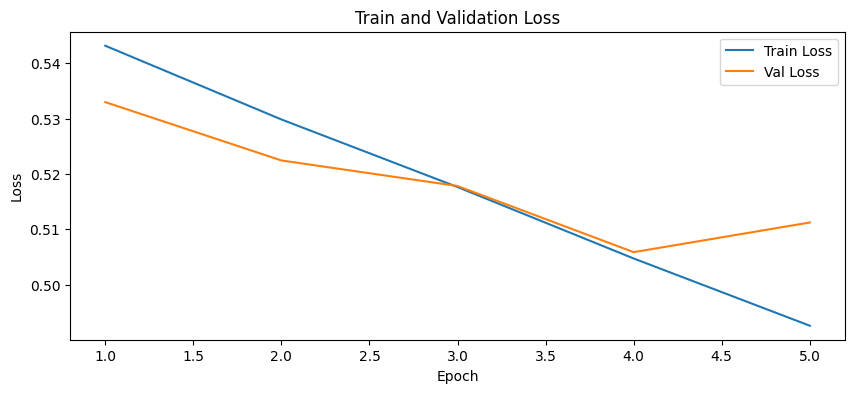

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

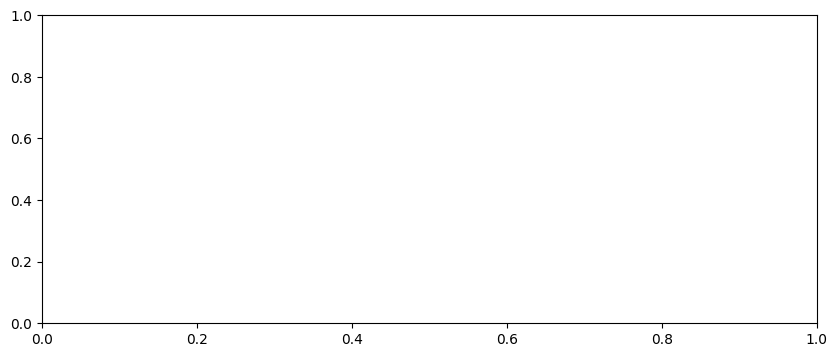

In [82]:
plt.figure(figsize=(10,4))
plt.plot(range(1, epoch+2), train_losses, label="Train Loss")
plt.plot(range(1, epoch+2), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(1, epoch+2), val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [84]:
# testing

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend  (labels.cpu().numpy())

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Testing Accuracy: {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Testing Accuracy: 75.61%

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79     20135
           1       0.74      0.69      0.71     15801

    accuracy                           0.76     35936
   macro avg       0.75      0.75      0.75     35936
weighted avg       0.76      0.76      0.76     35936

Confusion Matrix:
[[16256  3879]
 [ 4887 10914]]
